In [4]:
from keras.applications import ResNet50,ResNet152V2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
#!unzip /content/drive/MyDrive/christmas/person_detection.zip

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

# Preparing Training Data

In [9]:
train_dir='/Users/shikha/Documents/person_detection/train' 
validation_dir='/Users/shikha/Documents/person_detection/validation'

In [10]:
!pipreqs

In [11]:
train_cloud_dir = os.path.join(train_dir, 'Ubereat')
os.mkdir(train_cloud_dir)

train_foggy_dir = os.path.join(train_dir, 'Dunzo')
os.mkdir(train_foggy_dir)

train_foggy_dir = os.path.join(train_dir, 'others')
os.mkdir(train_foggy_dir)

In [12]:
validation_cloud_dir = os.path.join(validation_dir, 'Ubereat')
os.mkdir(validation_cloud_dir)

validation_foggy_dir = os.path.join(validation_dir, 'Dunzo')
os.mkdir(validation_foggy_dir)

validation_foggy_dir = os.path.join(validation_dir, 'others')
os.mkdir(validation_foggy_dir)

In [24]:
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    valid_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    valid_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALIDATION + filename
        copyfile(this_file, destination)

In [8]:
!rm -rf -r /content/person_detection/Ubereat

In [26]:
SWIGGY_SOURCE_DIR = '/Users/shikha/Documents/person_detection/Ubereat/'
TRAINING_SWIGGY_DIR = '/Users/shikha/Documents/person_detection/train/Ubereat/'
VALID_SWIGGY_DIR = '/Users/shikha/Documents/person_detection/validation/Ubereat/'

DUNZO_SOURCE_DIR = '/Users/shikha/Documents/person_detection/Dunzo/'
TRAINING_DUNZO_DIR = '/Users/shikha/Documents/person_detection/train/Dunzo/'
VALID_DUNZO_DIR = '/Users/shikha/Documents/person_detection/validation/Dunzo/'

ZOMATO_SOURCE_DIR = '/Users/shikha/Documents/person_detection/others/'
TRAINING_ZOMATO_DIR = '/Users/shikha/Documents/person_detection/train/others/'
VALID_ZOMATO_DIR = '/Users/shikha/Documents/person_detection/validation/others/'

In [27]:
import os
import random
from shutil import copyfile

split_size = .85

split_data(SWIGGY_SOURCE_DIR, TRAINING_SWIGGY_DIR, VALID_SWIGGY_DIR, split_size)
split_data(ZOMATO_SOURCE_DIR, TRAINING_ZOMATO_DIR, VALID_ZOMATO_DIR, split_size)
split_data(DUNZO_SOURCE_DIR, TRAINING_DUNZO_DIR, VALID_DUNZO_DIR, split_size)

In [29]:
import glob

train_dir = '/Users/shikha/Documents/person_detection/train'
classes = os.listdir(train_dir)
num_images = {}

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    images = glob.glob(class_path + '/*.jpg')
    num_images[class_name] = len(images)

print(num_images)

{'.DS_Store': 0, 'zomato': 300, 'others': 357, 'Dunzo': 154, 'Ubereat': 218, 'swiggy': 325}


In [12]:
img_width=256; img_height=256
batch_size=16

In [13]:

TRAINING_DIR = '/Users/shikha/Documents/person_detection/train' 

train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))

Found 1354 images belonging to 5 classes.


In [14]:
VALIDATION_DIR = '/Users/shikha/Documents/person_detection/validation/'

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 372 images belonging to 5 classes.


In [15]:

callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
# autosave best Model
best_model_file = '/content/CNN_aug_best_weights.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

In [16]:
# Define constants
NUM_CLASSES = 5  # Number of classes in the classification task
IMG_SIZE = (224, 224)  # Image size for ResNet50

# Training Using pretrained Resnet50 weights

In [17]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

# Add custom head to the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

2023-04-19 14:38:04.613786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
## Accuracy of Resnet50 after 10 epochs#
#Test loss: 1.3721126317977905
#Test accuracy: 0.3121951222419739

In [19]:
# using Inception V3
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# Training Using pretrained InceptionV3 weights¶

In [20]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# don't train existing weights
# Add custom head to the pre-trained model
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=inception.input, outputs=predictions)

In [67]:
## Accuracy of InceptionV3 after 10 epochs
#Test loss: 0.5956321358680725
#Test accuracy: 0.8487805128097534

In [71]:
! rm -rf -r /content/person_detection

# Training Using pretrained ResNet152V2 weights

In [68]:
import keras
resnet =keras.applications.ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# don't train existing weights
# Add custom head to the pre-trained model
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=predictions)

In [13]:
## Accuracy of ResNet152V2 after 10 epochs
#Test loss: 0.5792665481567383
#Test accuracy: 0.8536585569381714

# Model Training

In [21]:

model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics =['accuracy'])

In [22]:
history = model.fit_generator(train_generator,
                              epochs=10,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [best_model]
                              )

Epoch 1/10
85/85 [==============================] - 179s 2s/step - loss: 1.0626 - accuracy: 0.5864 - val_loss: 10.7230 - val_accuracy: 0.4005
Epoch 2/10
85/85 [==============================] - 177s 2s/step - loss: 0.7203 - accuracy: 0.7341 - val_loss: 3.2643 - val_accuracy: 0.6290
Epoch 3/10
85/85 [==============================] - 172s 2s/step - loss: 0.6133 - accuracy: 0.7777 - val_loss: 2.3834 - val_accuracy: 0.6048
Epoch 4/10
85/85 [==============================] - 177s 2s/step - loss: 0.5469 - accuracy: 0.7895 - val_loss: 3.7333 - val_accuracy: 0.5484
Epoch 5/10
85/85 [==============================] - 174s 2s/step - loss: 0.5881 - accuracy: 0.7733 - val_loss: 4.5577 - val_accuracy: 0.3763
Epoch 6/10
85/85 [==============================] - 173s 2s/step - loss: 0.5295 - accuracy: 0.7954 - val_loss: 1.4330 - val_accuracy: 0.6989
Epoch 7/10
85/85 [==============================] - 173s 2s/step - loss: 0.4763 - accuracy: 0.8250 - val_loss: 1.4625 - val_accuracy: 0.7366
Epoch 8/10
8

# Evaluate the model

In [24]:
# Evaluate the model
score = model.evaluate_generator(validation_generator, steps=len(validation_generator))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6670336723327637
Test accuracy: 0.8387096524238586


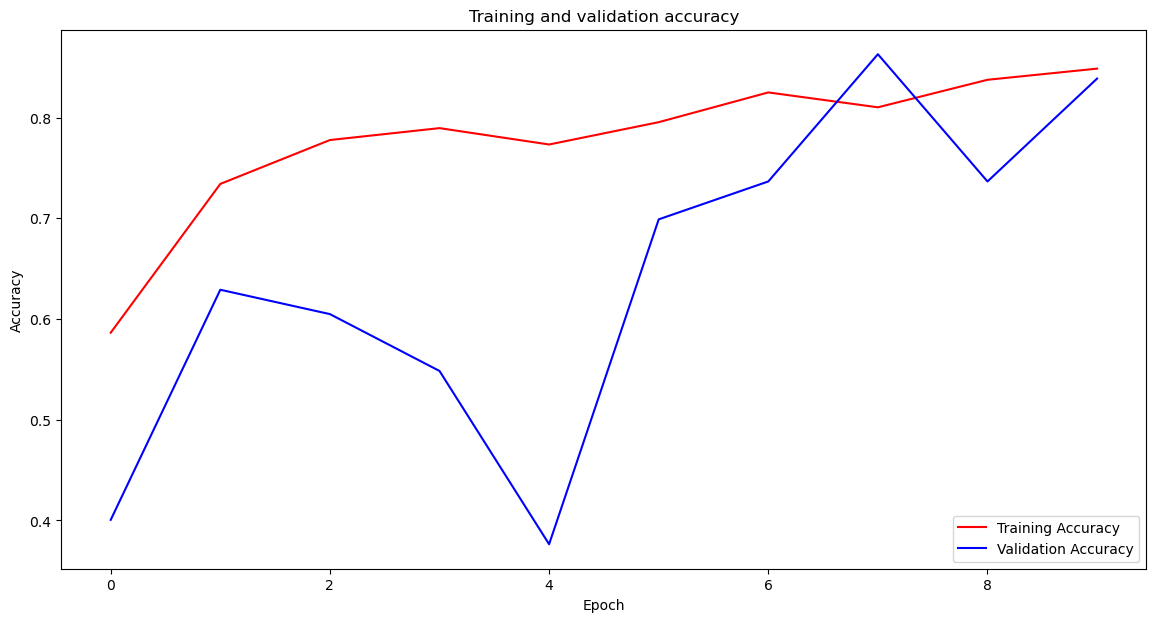

In [25]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [47]:
from google.colab import files
files.download("/content/person_detection/inceptionv3.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
from tensorflow.keras.models import load_model

model.save('/Users/shikha/Documents/inceptionv31.h5')


In [4]:
model = load_model('/Users/shikha/Documents/inceptionv3.h5')

2023-04-18 22:30:02.660177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate predictions for test set
y_pred = model.predict(validation_generator)

# Convert predicted probabilities to predicted class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get true class labels
y_true_labels = validation_generator.classes

# Print confusion matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)
print(conf_mat)



24/24 [==============================] - 13s 510ms/step
[[ 0  7 12  4  5]
 [ 5 14 31 24 15]
 [ 3 43 41 39 12]
 [ 1 16 27 14  5]
 [ 2 20 13  9 10]]


In [30]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load and preprocess the test image
#img_path = '/Users/shikha/Documents/person_detection_prev/zomato/images166_3.jpg'  # Update with the path to your test image
img_path='/Users/shikha/Documents/person_detection_prev/others/images233_1.jpg'
img = load_img(img_path, target_size=(224, 224))  # Assumes image size of (224, 224) for ResNet50
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values


In [31]:
# Get the class indices from the train generator
class_indices = validation_generator.class_indices

# Reverse the dictionary mapping class indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

print(class_labels)

# Make predictions on the test image
predictions = model.predict(img_array)

# Get the predicted class index with the highest probability
predicted_class_index = np.argmax(predictions)

# Get the corresponding class label
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class label:", predicted_class_label)
#{0: 'Dunzo', 1: 'Ubereat', 2: 'others', 3: 'swiggy', 4: 'zomato'}

{0: 'Dunzo', 1: 'Ubereat', 2: 'others', 3: 'swiggy', 4: 'zomato'}
1/1 [==============================] - 0s 68ms/step
Predicted class label: others
